# DeepLabv3 transfer learning implementation


## Import pretrained model Deeplabv3

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torch
import os

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

%matplotlib widget

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from ModelBuilder.DenseNet.DenseNet201_DeepLab import DenseNet201DeepLab
from ModelBuilder3D.Inception.InceptionV3_DeepLab import InceptionV3DeepLab
from ModelBuilder.ConvNeXt.ConvNeXt_DeepLab import ConvNeXtDeepLab


In [2]:
transform_image = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias = True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])
transform_mask = transforms.Compose(
    [
     transforms.ToTensor()
     ])

path = 'G:/MachineLearning/liver-database/'
save_path = 'G:/MachineLearning/models/'
#path = 'segmentations/'
dataset_learn = LiverDataset3D(path + 'validation/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_learn = torch.utils.data.DataLoader(dataset_learn, batch_size=2, shuffle=True, num_workers=8)

dataset_test = LiverDataset(path + 'testing/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_test = torch.utils.data.DataLoader(dataset_learn, batch_size=2, shuffle=True, num_workers=8)

## Vizualizam o imagine din dataset

torch.Size([512, 512])
tensor(1.)


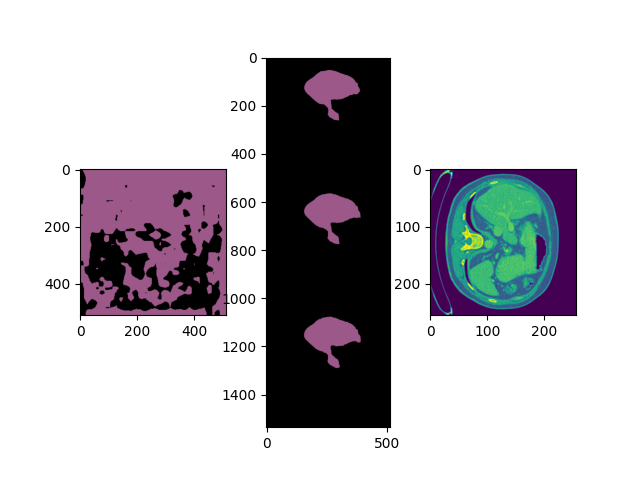

In [3]:
model_checkpoint = 'G:/MachineLearning/models/Inception/Inception_checkpoint.pt'
# model = torch.load(model_checkpoint, map_location=torch.device('cpu'))
model = InceptionV3DeepLab()
# checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
# model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cpu')
model.to(device)
show_model_seg(model, dataset_learn, 583)